<a href="https://colab.research.google.com/github/sparsh-ai/reco-book/blob/stage/nbs/T881207_BST_PTLightning_ML1M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rating prediction using the Behavior Sequence Transformer (BST) model on ML-1M dataset in PyTorch Lightning

Dataset: ML-1M
<br>
Reference: https://github.com/jiwidi/Behavior-Sequence-Transformer-Pytorch
<br>
Environment: PyTorch Lightning
<br>
Description: Implementing BST model from scratch in PyTorch Lightning on movielens 1M dataset

## Setup

In [ ]:
!pip install -q pytorch_lightning

In [ ]:
import pandas as pd
import torch
import pytorch_lightning as pl
from tqdm import tqdm
import torchmetrics
import math
from urllib.request import urlretrieve
from zipfile import ZipFile
import os
import torch.nn as nn
import numpy as np
from math import sqrt

In [ ]:
WINDOW_SIZE = 20

## Dataset

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [ ]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"]
)

In [ ]:
## Movies
movies["year"] = movies["title"].apply(lambda x: x[-5:-1])
movies.year = pd.Categorical(movies.year)
movies["year"] = movies.year.cat.codes
## Users
users.sex = pd.Categorical(users.sex)
users["sex"] = users.sex.cat.codes


users.age_group = pd.Categorical(users.age_group)
users["age_group"] = users.age_group.cat.codes


users.occupation = pd.Categorical(users.occupation)
users["occupation"] = users.occupation.cat.codes


users.zip_code = pd.Categorical(users.zip_code)
users["zip_code"] = users.zip_code.cat.codes

#Ratings
ratings['unix_timestamp'] = pd.to_datetime(ratings['unix_timestamp'],unit='s')


In [ ]:
# Save primary csv's
if not os.path.exists('data'):
    os.makedirs('data')
    
    
users.to_csv("data/users.csv",index=False)
movies.to_csv("data/movies.csv",index=False)
ratings.to_csv("data/ratings.csv",index=False)

In [ ]:
## Movies
movies["movie_id"] = movies["movie_id"].astype(str)
## Users
users["user_id"] = users["user_id"].astype(str)

##Ratings 
ratings["movie_id"] = ratings["movie_id"].astype(str)
ratings["user_id"] = ratings["user_id"].astype(str)

In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )


## Transform the movie ratings data into sequences

First, let's sort the the ratings data using the `unix_timestamp`, and then group the
`movie_id` values and the `rating` values by `user_id`.

The output DataFrame will have a record for each `user_id`, with two ordered lists
(sorted by rating datetime): the movies they have rated, and their ratings of these movies.

In [ ]:
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)


Now, let's split the `movie_ids` list into a set of sequences of a fixed length.
We do the same for the `ratings`. Set the `sequence_length` variable to change the length
of the input sequence to the model. You can also change the `step_size` to control the
number of sequences to generate for each user.

In [ ]:
sequence_length = 8
step_size = 1


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

After that, we process the output to have each sequence in a separate records in
the DataFrame. In addition, we join the user features with the ratings data.

In [ ]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

With `sequence_length` of 4 and `step_size` of 2, we end up with 498,623 sequences.

Finally, we split the data into training and testing splits, with 85% and 15% of
the instances, respectively, and store them to CSV files.

In [ ]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("data/train_data.csv", index=False, sep=",")
test_data.to_csv("data/test_data.csv", index=False, sep=",")

In [ ]:
test_data

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
9,1,"260,720,1193,919,608,2692,1961,2028","4,3,5,4,4,4,5,5",0,0,10
11,1,"1193,919,608,2692,1961,2028,3105,938","5,4,4,4,5,5,5,4",0,0,10
12,1,"919,608,2692,1961,2028,3105,938,1035","4,4,4,5,5,5,4,5",0,0,10
13,1,"608,2692,1961,2028,3105,938,1035,1962","4,4,5,5,5,4,5,4",0,0,10
25,1,"914,1287,2797,1246,2762,661,2918,531","3,5,4,4,4,3,4,4",0,0,10
...,...,...,...,...,...,...
963899,999,"1012,14,3510,1805,1059,45,3261,2245","4,2,5,3,3,2,3,4",1,2,15
963927,999,"3176,354,524,280,2447,1515,724,266","4,4,4,4,3,1,2,4",1,2,15
963938,999,"382,1027,1442,2146,358,2541,2431,1727","3,4,4,3,4,3,4,3",1,2,15
963947,999,"2320,996,3513,3109,3156,282,1888,209","3,2,3,3,4,4,3,2",1,2,15


## Load the processed datasets

In [ ]:
import pandas as pd
import torch
import pytorch_lightning as pl
from tqdm import tqdm
import torchmetrics
import math
from urllib.request import urlretrieve
from zipfile import ZipFile
import os
import torch.nn as nn
import numpy as np

In [ ]:
users = pd.read_csv(
    "data/users.csv",
    sep=",",
)

ratings = pd.read_csv(
    "data/ratings.csv",
    sep=",",
)

movies = pd.read_csv(
    "data/movies.csv", sep=","
)

## Convert into Pytorch dataset

In [ ]:
import pandas as pd
import torch
import torch.utils.data as data
from torchvision import transforms
import ast
from torch.nn.utils.rnn import pad_sequence

class MovieDataset(data.Dataset):
    """Movie dataset."""

    def __init__(
        self, ratings_file,test=False
    ):
        """
        Args:
            csv_file (string): Path to the csv file with user,past,future.
        """
        self.ratings_frame = pd.read_csv(
            ratings_file,
            delimiter=",",
            # iterator=True,
        )
        self.test = test

    def __len__(self):
        return len(self.ratings_frame)

    def __getitem__(self, idx):
        data = self.ratings_frame.iloc[idx]
        user_id = data.user_id
        
        movie_history = eval(data.sequence_movie_ids)
        movie_history_ratings = eval(data.sequence_ratings)
        target_movie_id = movie_history[-1:][0]
        target_movie_rating = movie_history_ratings[-1:][0]
        
        movie_history = torch.LongTensor(movie_history[:-1])
        movie_history_ratings = torch.LongTensor(movie_history_ratings[:-1])

        
        
        sex = data.sex
        age_group = data.age_group
        occupation = data.occupation
        
        return user_id, movie_history, target_movie_id,  movie_history_ratings, target_movie_rating, sex, age_group, occupation

In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )
    
sequence_length = 8

## Model Implementation and Training

In [ ]:
class BST(pl.LightningModule):
    def __init__(
        self, args=None,
    ):
        super().__init__()
        super(BST, self).__init__()
        
        self.save_hyperparameters()
        self.args = args
        #-------------------
        # Embedding layers
        ##Users 
        self.embeddings_user_id = nn.Embedding(
            int(users.user_id.max())+1, int(math.sqrt(users.user_id.max()))+1
        )
        ###Users features embeddings
        self.embeddings_user_sex = nn.Embedding(
            len(users.sex.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        self.embeddings_age_group = nn.Embedding(
            len(users.age_group.unique()), int(math.sqrt(len(users.age_group.unique())))
        )
        self.embeddings_user_occupation = nn.Embedding(
            len(users.occupation.unique()), int(math.sqrt(len(users.occupation.unique())))
        )
        self.embeddings_user_zip_code = nn.Embedding(
            len(users.zip_code.unique()), int(math.sqrt(len(users.sex.unique())))
        )
        
        ##Movies
        self.embeddings_movie_id = nn.Embedding(
            int(movies.movie_id.max())+1, int(math.sqrt(movies.movie_id.max()))+1
        )
        self.embeddings_position  = nn.Embedding(
           sequence_length, int(math.sqrt(len(movies.movie_id.unique())))+1
        )
        ###Movies features embeddings
        genre_vectors = movies[genres].to_numpy()
        self.embeddings_movie_genre = nn.Embedding(
            genre_vectors.shape[0], genre_vectors.shape[1]
        )
        
        self.embeddings_movie_genre.weight.requires_grad = False #Not training genres
        
        
        self.embeddings_movie_year = nn.Embedding(
            len(movies.year.unique()), int(math.sqrt(len(movies.year.unique())))
        )
        
        
        # Network
        self.transfomerlayer = nn.TransformerEncoderLayer(63, 3, dropout=0.2)
        self.linear = nn.Sequential(
            nn.Linear(
                589,
                1024,
            ),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
        )
        self.criterion = torch.nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        
    def encode_input(self,inputs):
        user_id, movie_history, target_movie_id,  movie_history_ratings, target_movie_rating, sex, age_group, occupation = inputs
        
        
        #MOVIES
        movie_history = self.embeddings_movie_id(movie_history)
        target_movie = self.embeddings_movie_id(target_movie_id)
        
        positions = torch.arange(0,sequence_length-1,1,dtype=int,device=self.device)
        positions = self.embeddings_position(positions)
        
        encoded_sequence_movies_with_poistion_and_rating = (movie_history + positions) #Yet to multiply by rating
        
        target_movie = torch.unsqueeze(target_movie, 1)
        transfomer_features = torch.cat((encoded_sequence_movies_with_poistion_and_rating, target_movie),dim=1)
        
        #USERS
        user_id = self.embeddings_user_id(user_id)
        
        sex = self.embeddings_user_sex(sex)
        age_group = self.embeddings_age_group(age_group)
        occupation = self.embeddings_user_occupation(occupation)
        user_features = torch.cat((user_id, sex, age_group,occupation), 1)
        
        return transfomer_features, user_features, target_movie_rating.float()
    
    def forward(self, batch):
        transfomer_features, user_features, target_movie_rating = self.encode_input(batch)
        transformer_output = self.transfomerlayer(transfomer_features)
        transformer_output = torch.flatten(transformer_output,start_dim=1)
        
        #Concat with other features
        features = torch.cat((transformer_output,user_features),dim=1)
        
        output = self.linear(features)
        return output, target_movie_rating
        
    def training_step(self, batch, batch_idx):
        out, target_movie_rating = self(batch)
        out = out.flatten()
        loss = self.criterion(out, target_movie_rating)
        
        mae = self.mae(out, target_movie_rating)
        mse = self.mse(out, target_movie_rating)
        rmse =torch.sqrt(mse)
        self.log(
            "train/mae", mae, on_step=True, on_epoch=False, prog_bar=False
        )
        
        self.log(
            "train/rmse", rmse, on_step=True, on_epoch=False, prog_bar=False
        )
        
        self.log("train/step_loss", loss, on_step=True, on_epoch=False, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        out, target_movie_rating = self(batch)
        out = out.flatten()
        loss = self.criterion(out, target_movie_rating)
        
        mae = self.mae(out, target_movie_rating)
        mse = self.mse(out, target_movie_rating)
        rmse =torch.sqrt(mse)
        
        return {"val_loss": loss, "mae": mae.detach(), "rmse":rmse.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_mae = torch.stack([x["mae"] for x in outputs]).mean()
        avg_rmse = torch.stack([x["rmse"] for x in outputs]).mean()
        
        self.log("val/loss", avg_loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/mae", avg_mae, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/rmse", avg_rmse, on_step=False, on_epoch=True, prog_bar=False)


    def test_epoch_end(self, outputs):
        users = torch.cat([x["users"] for x in outputs])
        y_hat = torch.cat([x["top14"] for x in outputs])
        users = users.tolist()
        y_hat = y_hat.tolist()
        
        data = {"users": users, "top14": y_hat}
        df = pd.DataFrame.from_dict(data)
        print(len(df))
        df.to_csv("lightning_logs/predict.csv", index=False)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0005)

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--learning_rate", type=float, default=0.01)
        return parser

    ####################
    # DATA RELATED HOOKS
    ####################

    def setup(self, stage=None):
        print("Loading datasets")
        self.train_dataset = MovieDataset("data/train_data.csv")
        self.val_dataset = MovieDataset("data/test_data.csv")
        self.test_dataset = MovieDataset("data/test_data.csv")
        print("Done")

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=128,
            shuffle=False,
            num_workers=os.cpu_count(),
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=128,
            shuffle=False,
            num_workers=os.cpu_count(),
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=128,
            shuffle=False,
            num_workers=os.cpu_count(),
        )
        
model = BST()
trainer = pl.Trainer(gpus=1,max_epochs=2)
trainer.fit(model)

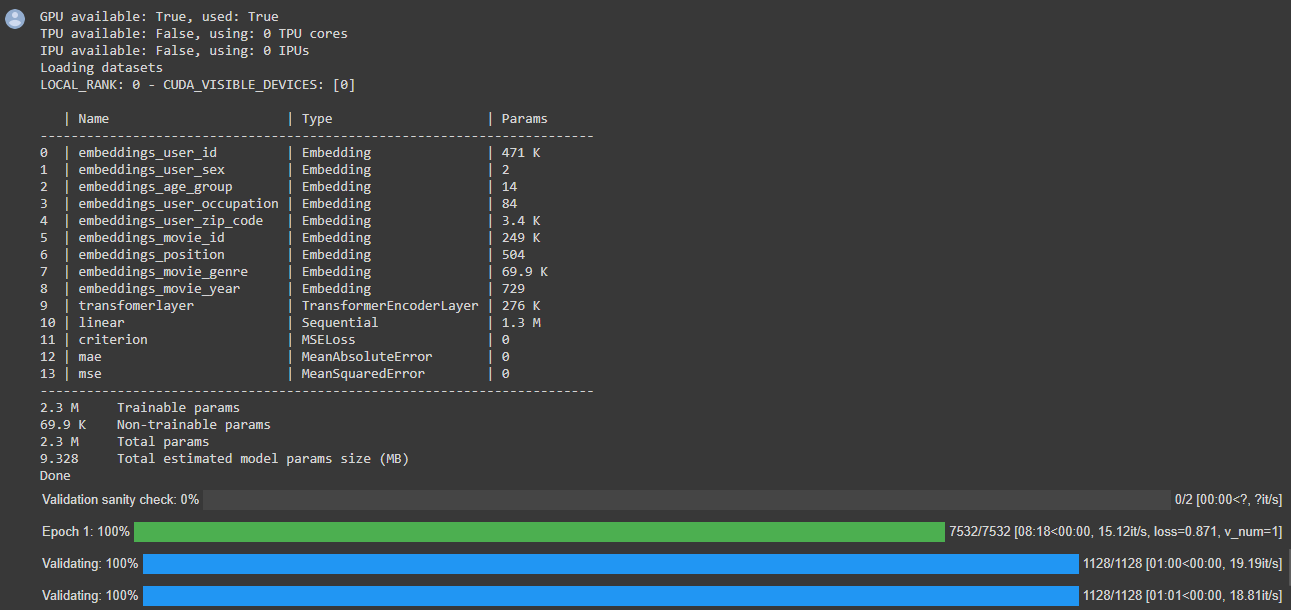